In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import earthkit.data as ekd 

In [2]:
output_path = "/ec/res4/hpcperm/nld4584/output_inference/output_benchmark_inference.grib"
dataset_path = "/home/mlx/ai-ml/datasets/aifs-ea-an-oper-0001-mars-o96-1979-2023-6h-v8.zarr"

In [3]:


ds_dataset = xr.open_zarr(dataset_path)
times = ds_dataset.dates.values
times

/etc/ecmwf/ssd/ssd1/tmpdirs/nld4584.4125684.20251121_103636.729/ipykernel_309429/3962537751.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_dataset = xr.open_zarr(dataset_path)


array(['1979-01-01T00:00:00', '1979-01-01T06:00:00',
       '1979-01-01T12:00:00', ..., '2023-12-31T06:00:00',
       '2023-12-31T12:00:00', '2023-12-31T18:00:00'],
      shape=(65744,), dtype='datetime64[s]')

In [4]:

source = ekd.from_source("file", str(output_path)) 
t2m_model = source.sel(shortName="2t")

In [5]:
print(t2m_model.values)

[[271.2706604  271.29019165 271.1847229  ... 223.8487854  223.53237915
  223.13394165]
 [272.0604248  272.037323   272.18624878 ... 225.10046387 224.71867371
  224.01087952]
 [271.8147583  272.03640747 272.44445801 ... 225.38117981 224.7973175
  224.18806458]
 ...
 [265.07382202 265.30563354 265.02679443 ... 221.19206238 222.99829102
  217.04032898]
 [264.78341675 264.99505615 264.7835083  ... 221.16430664 222.93963623
  216.01699829]
 [264.37597656 264.64141846 264.45565796 ... 220.91368103 222.70536804
  215.44895935]]


In [6]:
var_names = ds_dataset.attrs["variables"]
idx_2t = var_names.index("2t")
t2m_dataset= ds_dataset["data"].isel(variable=idx_2t)




In [7]:
init_time = np.datetime64("2022-09-01T00:00")
t0 = np.where(times == init_time)[0][0]
print("Index of init time:", t0)

Index of init time: 63796


In [8]:
n_steps = source.sel(shortName="2t").values.shape[0]

In [9]:
idx_2t = ds_dataset.attrs["variables"].index("2t")

t2m_truth_slice = ds_dataset["data"].isel(
    variable=idx_2t,
    time=slice(t0, t0 + n_steps)
)

In [10]:
t2m_truth_slice

<xarray.DataArray 'data' (time: 101, ensemble: 1, cell: 40320)> Size: 16MB
dask.array<getitem, shape=(101, 1, 40320), dtype=float32, chunksize=(1, 1, 40320), chunktype=numpy.ndarray>
Dimensions without coordinates: time, ensemble, cell

In [11]:
mse_all = []
for i in range(n_steps):
    mse = (t2m_truth_slice[i][0].values - t2m_model.values[i])**2
    mse_all.append(mse)
    

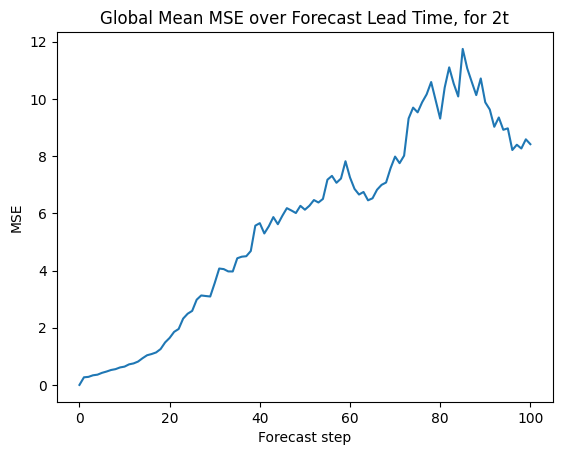

In [12]:
mse_all = np.array(mse_all)  # shape: (n_steps, 40320)

# Compute global mean per step
mse_mean = mse_all.mean(axis=1)

plt.plot(mse_mean)
plt.xlabel("Forecast step")
plt.ylabel("MSE")
plt.title("Global Mean MSE over Forecast Lead Time, for 2t")
plt.show()

In [13]:
print(str(source.ls()))

     centre shortName        typeOfLevel  level  dataDate  dataTime stepRange  \
0      ecmf       10u  heightAboveGround     10  20220901         0         0   
1      ecmf       10v  heightAboveGround     10  20220901         0         0   
2      ecmf        2d  heightAboveGround      2  20220901         0         0   
3      ecmf        2t  heightAboveGround      2  20220901         0         0   
4      ecmf       lsm            surface      0  20220901         0         0   
...     ...       ...                ...    ...       ...       ...       ...   
8885   ecmf         z      isobaricInhPa    500  20220901         0       600   
8886   ecmf         z      isobaricInhPa    600  20220901         0       600   
8887   ecmf         z      isobaricInhPa    700  20220901         0       600   
8888   ecmf         z      isobaricInhPa    850  20220901         0       600   
8889   ecmf         z      isobaricInhPa    925  20220901         0       600   

     dataType number    gri

In [10]:
ds_model = ekd.from_source("file", output_path)

In [15]:
ds_model.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10u,heightAboveGround,10,20220901,0,0,fc,None,reduced_gg
1,ecmf,10v,heightAboveGround,10,20220901,0,0,fc,None,reduced_gg
2,ecmf,2d,heightAboveGround,2,20220901,0,0,fc,None,reduced_gg
3,ecmf,2t,heightAboveGround,2,20220901,0,0,fc,None,reduced_gg
4,ecmf,lsm,surface,0,20220901,0,0,fc,None,reduced_gg
...,...,...,...,...,...,...,...,...,...,...
8885,ecmf,z,isobaricInhPa,500,20220901,0,600,fc,None,reduced_gg
8886,ecmf,z,isobaricInhPa,600,20220901,0,600,fc,None,reduced_gg
8887,ecmf,z,isobaricInhPa,700,20220901,0,600,fc,None,reduced_gg
8888,ecmf,z,isobaricInhPa,850,20220901,0,600,fc,None,reduced_gg


In [16]:
ds_model.indices()

{'class': ['od'],
 'stream': ['oper'],
 'levtype': ['pl', 'sfc'],
 'type': ['fc'],
 'expver': ['0001'],
 'date': [20220901],
 'time': [0],
 'domain': ['g'],
 'param': ['10u',
  '10v',
  '2d',
  '2t',
  'cp',
  'lsm',
  'msl',
  'q',
  'sdor',
  'skt',
  'slor',
  'sp',
  't',
  'tcw',
  'tp',
  'u',
  'v',
  'w',
  'z'],
 'levelist': [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]}

In [17]:
for f in ds_model.sel(typeOfLevel="isobaricInhPa"):
    print(f)

GribField(q,100,20220901,0,0,None)
GribField(q,1000,20220901,0,0,None)
GribField(q,150,20220901,0,0,None)
GribField(q,200,20220901,0,0,None)
GribField(q,250,20220901,0,0,None)
GribField(q,300,20220901,0,0,None)
GribField(q,400,20220901,0,0,None)
GribField(q,50,20220901,0,0,None)
GribField(q,500,20220901,0,0,None)
GribField(q,600,20220901,0,0,None)
GribField(q,700,20220901,0,0,None)
GribField(q,850,20220901,0,0,None)
GribField(q,925,20220901,0,0,None)
GribField(t,100,20220901,0,0,None)
GribField(t,1000,20220901,0,0,None)
GribField(t,150,20220901,0,0,None)
GribField(t,200,20220901,0,0,None)
GribField(t,250,20220901,0,0,None)
GribField(t,300,20220901,0,0,None)
GribField(t,400,20220901,0,0,None)
GribField(t,50,20220901,0,0,None)
GribField(t,500,20220901,0,0,None)
GribField(t,600,20220901,0,0,None)
GribField(t,700,20220901,0,0,None)
GribField(t,850,20220901,0,0,None)
GribField(t,925,20220901,0,0,None)
GribField(u,100,20220901,0,0,None)
GribField(u,1000,20220901,0,0,None)
GribField(u,150,202

In [11]:
llv = ds_model[0].data() #longetude, latitude, values

In [19]:
print(llv[1].shape)
# first latitude
llv[2, 1000]

(40320,)


-3.957305908203125

In [20]:
llv[0][:].shape

(40320,)

In [12]:
#constant
p0 = 1000 # hPa
R_over_cp = 0.286

In [13]:
t_model = ds_model.sel(shortName="t").values

In [14]:
t_model.shape

(1313, 40320)

In [15]:
n_timesteps = 101
n_levels = 13
n_cells = 40320

# reshape: (time, level, cells)
T = t_model.reshape(n_timesteps, n_levels, n_cells)
p_levels = np.array([50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000],)


In [16]:
p0 = 1000.0  # reference hPa
R_over_cp = 0.286

# reshape pressure levels to broadcast: (1, level, 1)
p_reshaped = p_levels.reshape(1, n_levels, 1)

# potential temperature
theta = T * (p0 / p_reshaped)**R_over_cp

In [17]:
u_model = ds_model.sel(shortName="u").values
v_model = ds_model.sel(shortName="v").values
w_model = ds_model.sel(shortName="w").values

In [18]:
u = u_model.reshape(n_timesteps, n_levels, n_cells)
v = v_model.reshape(n_timesteps, n_levels, n_cells)
w = w_model.reshape(n_timesteps, n_levels, n_cells) 

In [19]:
lat = llv[0]
lon = llv[1]

# Convert lat/lon to Cartesian coordinates (meters)
R_earth = 6371000.0
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)
x = R_earth * np.cos(lat_rad) * np.cos(lon_rad)
y = R_earth * np.cos(lat_rad) * np.sin(lon_rad)
z = R_earth * np.sin(lat_rad)
coords = np.stack([x, y, z], axis=1)

In [20]:
# Build KDTree
tree = cKDTree(coords)
k = 6
distances, indices = tree.query(coords, k=k+1)  # +1 includes self
distances = distances[:,1:]  # remove self
indices = indices[:,1:]

In [21]:
dtheta_dx = np.zeros_like(theta)
dtheta_dy = np.zeros_like(theta)

for i in range(n_cells):
    neighbor_idx = indices[i]
    dist = distances[i]  # shape (k,)

    # differences
    dtheta = theta[:, :, neighbor_idx] - theta[:, :, i][:, :, np.newaxis]  # (time, level, k)
    
    # simple finite difference: divide by distance and average over neighbors
    dtheta_dx[:, :, i] = np.mean(dtheta / dist, axis=2)
    dtheta_dy[:, :, i] = np.mean(dtheta / dist, axis=2)

In [22]:
dtheta_dz = np.zeros_like(theta)
dp = np.diff(p_levels)  # hPa
for k_level in range(n_levels-1):
    dtheta_dz[:, k_level, :] = (theta[:, k_level+1, :] - theta[:, k_level, :]) / dp[k_level]
dtheta_dz[:, -1, :] = dtheta_dz[:, -2, :]  # copy last level derivative


R_d = 287.0  # J/(kg*K)
g = 9.81     # m/s^2
p_levels_pa = p_levels * 100  # hPa → Pa
p_reshaped_pa = p_levels_pa.reshape(1, n_levels, 1)  # broadcast

w_meters = - w * R_d * T / (p_reshaped_pa * g)

In [23]:

dtheta_dt = np.zeros_like(theta)
dtheta_dt[1:, :, :] = theta[1:, :, :] - theta[:-1, :, :]
dtheta_dt[0, :, :] = dtheta_dt[1, :, :]


DthetaDt = dtheta_dt + u*dtheta_dx + v*dtheta_dy + w_meters*dtheta_dz

print("DthetaDt shape:", DthetaDt.shape)

DthetaDt shape: (101, 13, 40320)


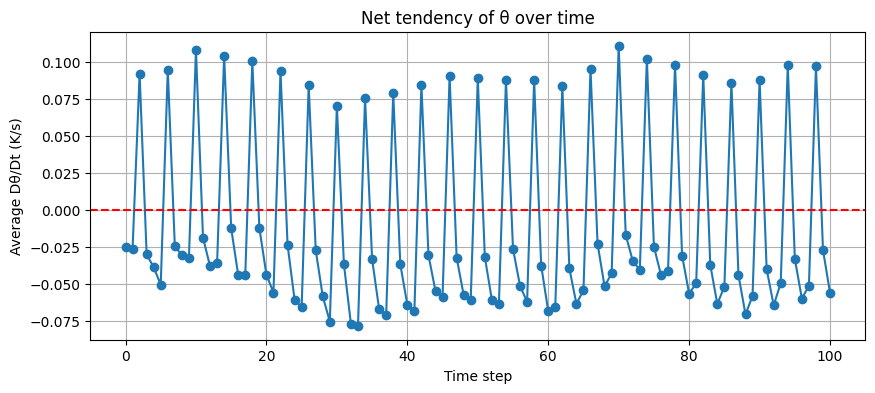

In [24]:
# Average over cells and levels
mean_DthetaDt_time = DthetaDt.mean(axis=(1,2))  # shape: (time,)

plt.figure(figsize=(10,4))
plt.plot(mean_DthetaDt_time, marker='o')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Time step")
plt.ylabel("Average Dθ/Dt (K/s)")
plt.title("Net tendency of θ over time")
plt.grid(True)
plt.show()

In [25]:
dataset_slice = ds_dataset["data"].isel(
    time=slice(t0, t0 + n_steps)
)

In [26]:
vars_t = [v for v in var_names if v.startswith("t_")]
vars_u = [v for v in var_names if v.startswith("u_")]
vars_v = [v for v in var_names if v.startswith("v_")] 
vars_w = [v for v in var_names if v.startswith("w_")]




In [27]:
vars_t_sorted = sorted(vars_t, key=lambda x: int(x.split("_")[1]))
vars_u_sorted = sorted(vars_u, key=lambda x: int(x.split("_")[1]))
vars_v_sorted = sorted(vars_v, key=lambda x: int(x.split("_")[1]))
vars_w_sorted = sorted(vars_w, key=lambda x: int(x.split("_")[1]))

t_indices_sorted = [var_names.index(v) for v in vars_t_sorted]
u_indices_sorted = [var_names.index(v) for v in vars_u_sorted]
v_indices_sorted = [var_names.index(v) for v in vars_v_sorted]
w_indices_sorted = [var_names.index(v) for v in vars_w_sorted]


In [28]:
t_dataset = dataset_slice.isel(variable=t_indices_sorted)
u_dataset = dataset_slice.isel(variable=u_indices_sorted)
v_dataset = dataset_slice.isel(variable=v_indices_sorted)
w_dataset = dataset_slice.isel(variable=w_indices_sorted)

In [29]:
t_dataset = t_dataset.squeeze(dim="ensemble")
u_dataset = u_dataset.squeeze(dim="ensemble")
v_dataset = v_dataset.squeeze(dim="ensemble")
w_dataset = w_dataset.squeeze(dim="ensemble")

In [30]:
theta_data = t_dataset * (p0 / p_reshaped)**R_over_cp

In [ ]:
dtheta_dx_data = np.zeros_like(theta_data)
dtheta_dy_data = np.zeros_like(theta_data)

for i in range(n_cells):
    neighbor_idx = indices[i]
    dist = distances[i]  # shape (k,)

    # differences
    dtheta = theta_data[:, :, neighbor_idx] - theta_data[:, :, i][:, :, np.newaxis]  # (time, level, k)
    
    # simple finite difference: divide by distance and average over neighbors
    dtheta_dx_data[:, :, i] = np.mean(dtheta / dist, axis=2)
    dtheta_dy_data[:, :, i] = np.mean(dtheta / dist, axis=2)